# Endowment Economy

## Calibration with non homothetic demand

In [7]:
using NLsolve, Plots, Parameters, Distributions, ProgressMeter, Statistics, StatsPlots

@with_kw struct Calibration
    #Households
    σ::Float64=0.5                      # elasticity of relative demand with respect to price sigma=0.5 completementary goods
    γ::Array{Float64}=[1/3, 1/3, 1/3]   # intensity in each good
    ϵ::Array{Float64}=[0.6, 1.0, 1.65]  # elasticity of relative demand with respect to income in luxury good sector
    ρ::Float64 =(σ-1)/σ                 
    β::Float64 = 0.96                   # Discount factor

    #Production
    α::Float64=0.4                      # Capital share
    δ::Float64=0.1                      # Capital depreciation
end

cal = Calibration()

Calibration
  σ: Float64 0.5
  γ: Array{Float64}((3,)) [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
  ϵ: Array{Float64}((3,)) [0.6, 1.0, 1.65]
  ρ: Float64 -1.0


## How we solve for non homothetic utility. 
- Endowment translates into wealth since it can be sold on the market. 
- Utility maximization by solving for demand non linearities yield the non homothetic demand.

In [8]:
#NH Utility Function
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    @unpack σ, γ, ϵ, ρ = cal

    E=sum(p[i]*C[i] for i=1:length(C))
    out=1-sum(γ[i]^(1/σ)*(((p[i]/E)^(-σ)*γ[i])/u^((1-σ)*σ*ϵ[i]))^ρ for i=1:length(C))
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal)
    @unpack σ, γ, ϵ, ρ = cal

    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C endowment
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    ExpNH=sum(γ[i]*U^(ϵ[i]*σ*(1-σ)) * (p[i]^(1-σ)) for i = 1:length(C))^(1/(1-σ))
    
    #Optimal Demand with income effect
    C1=γ[1]*U^(ϵ[1]*σ*(1-σ))  * (p[1]/E)^(-σ)
    C2=γ[2]*U^(ϵ[2]*σ*(1-σ))  * (p[2]/E)^(-σ)
    C3=γ[3]*U^(ϵ[3]*σ*(1-σ))  * (p[3]/E)^(-σ)

    #Expenditure share with income effect
    ω_p=γ[1]*U^(ϵ[1]*σ*(1-σ))  * (p[1]/E)^(1-σ)
    ω_n=γ[2]*U^(ϵ[2]*σ*(1-σ))  * (p[2]/E)^(1-σ)
    ω_l=γ[3]*U^(ϵ[3]*σ*(1-σ))  * (p[3]/E)^(1-σ)

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    return [C1, C2, C3, U]#, U, E, ω]

end

NHUtility (generic function with 1 method)

## Environment

In this example, prices were first given at p=[4.0, 5.0, 10.0].

However, this price level does not clear the market, we have demand that takes over endowment level in our economy. Hence we update the price level such that non homothetic is exactly equal to the endowment level.

We set 3 sectors with 300 agents.

### Random endowments

- Lognormal for luxury products
- Normal distribution for Primary and Normal, higher quantity for primary quantity

In terms of aggregate quantity : $ Q_P>Q_N>Q_L$

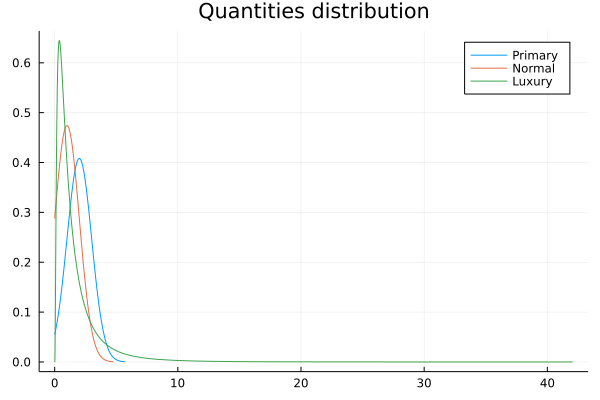

In [9]:
#Economy size
ng=3        #number of sector
na=800   #number of people
p=[4.0, 5.0, 10.0]

#Good matrix
G=zeros(na,ng)

#Quantities distribution for each person
D_P=Normal(2,1)
D_P = truncated(D_P, 0.0, Inf)
D_N=Normal(1,1)
D_N = truncated(D_N, 0.0, Inf)
D_L=LogNormal(0.02,1)
D_L = truncated(D_L, 0.0, Inf)


qdist=plot(D_P, title="Quantities distribution", label="Primary")
plot!(D_N, label="Normal")
plot!(D_L, label="Luxury")

savefig(qdist, "q_dist.png") # save the most recent fig as filename_string (such as "output.png")
qdist

(W, D, Excess, p) = ([1595.6937025608347, 997.4285572422423, 1314.490059973159], [1595.6937026666217, 997.4285668029312, 1314.4900522417793], [1.0578696674201638e-7, 9.560688909004966e-6, -7.731379810138606e-6], [1.5340491672298282, 6.746424186070274, 9.70468038778557])


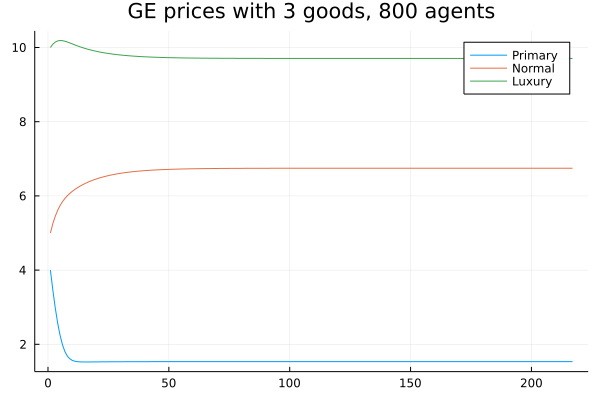

In [10]:
#Initial price level given
p=[4.0, 5.0, 10.0]

#leading to a Expenditure vector evaluated by a distribution of good
Exp=[]

for j=1:na
    G[j,1]=rand(D_P)
    G[j,2]=rand(D_N)
    G[j,3]=rand(D_L)
end

#Vectors and matrixes to store
W=zeros(ng)             #Endowment
D=zeros(ng)             #NH Demand
Excess=zeros(ng)
pricepath=[]

#iterations
tol=1e-5
iter=0
maxiter=500

#We are looking for a pricepath at the GE.
#First value for excess, 
#1. if D>W Price increases
#2. if D<W Price drops
for i=1:ng
    W[i]=sum(G[j,i] for j=1:na)
    D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)
end

Excess=D-W

for j =1:ng
    while iter<=maxiter && abs(Excess[j])>tol
        iter = iter + 1
        pricepath=push!(pricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.001*Excess[i]
            W[i]=sum(G[j,i] for j=1:na)
            D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)        
        end
        Excess=D-W
    end
end

@show W,D, Excess, p

pricep=pricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])

Suppose we know design a supply shock where a fifth of the Primary good aggregate quantity destroyed.

In [16]:
initial_p=p
Exp=[]
for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end

initial=[G Exp]
initial=sortslices(initial,dims=1,by=x->(x[4]),rev=false)
G=convert(Matrix{Float64},initial[:,[1,2,3]])

#after shock endowment level
n_G=copy(G)
s_shock=1/5
n_G[:,1]=G[:,1].*(1-s_shock)
n_G

800×3 Matrix{Float64}:
 0.771818    0.0984913   0.178682
 0.473163    0.124761    0.316211
 1.20907     0.109739    0.220689
 1.2146      0.365993    0.0741714
 0.00907761  0.608016    0.157397
 1.42745     0.0800938   0.246322
 1.31767     0.0634299   0.278871
 1.19159     0.309119    0.146142
 0.00783805  0.184458    0.484395
 0.277142    0.544552    0.201088
 ⋮                      
 0.954995    0.81819    10.399
 0.153995    0.291657   11.772
 0.440925    1.02962    11.3626
 1.98856     1.15144    11.3383
 2.03863     2.04254    10.9577
 1.04858     0.603279   12.3504
 0.984015    0.804132   14.359
 2.34244     2.11353    13.9021
 1.36015     1.9523     15.4769

Then continue to look for equilibrium at GE prices to find another GE with supply shock.

(W, D, Excess) = ([1312.5882784186697, 1039.27662337048, 1355.247522424595], [1312.5882787120765, 1039.2766328168323, 1355.247514770822], [2.934068561444292e-7, 9.446352351005771e-6, -7.653773081983672e-6])


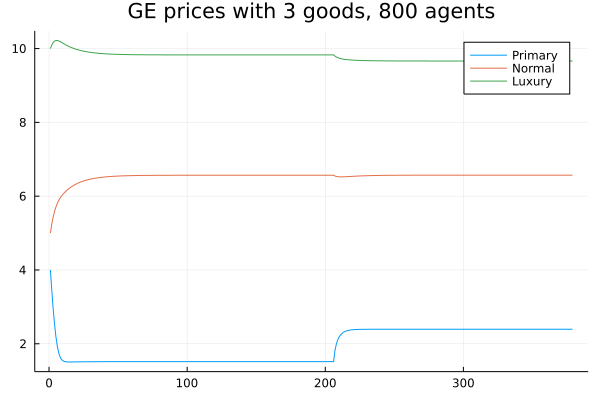

In [17]:
shockpricepath=pricepath
initial_p=[p[1], p[2], p[3]]

#After shock initial excess
for i=1:ng
    W[i]=sum(n_G[j,i] for j=1:na)
    D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)
end

Excess=D-W

iter_shock=0

for j =1:ng
    while iter_shock<=maxiter && abs(Excess[j])>tol
        iter_shock = iter_shock + 1
        shockpricepath=push!(shockpricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.001*Excess[i]
            W[i]=sum(n_G[j,i] for j=1:na)
            D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)        
        end
    Excess=D-W
    end
end

after_shock_p=p
pricep=shockpricepath

p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

@show W,D, Excess
pge=plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])
savefig(pge, "ge_prices.png") # save the most recent fig as filename_string (such as "output.png")

pge

In [18]:
initial_p, after_shock_p,p

([1.5166475298170294, 6.567640714210723, 9.828078824888589], [2.3944611252155332, 6.5696045206255835, 9.662881377583803], [2.3944611252155332, 6.5696045206255835, 9.662881377583803])

In [19]:
A=[]
B=[]

Exp=[]
C_P=[]
C_N=[]
C_L=[]
U=[]
#Deciles
for j=1:10
    for i=1:na/10
        A=push!(A,Int(i))
        B=push!(B,Int(j))
    end
end

#Initial endowment with GE prices

for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    C1=NHUtility(G[a,:],initial_p)[1]
    C2=NHUtility(G[a,:],initial_p)[2]
    C3=NHUtility(G[a,:],initial_p)[3]
    Utility=NHUtility(G[a,:],initial_p)[4]

    
    Exp=push!(Exp,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
#initial=sortslices(initial,dims=1,by=x->(x[1]),rev=false)

initial= [A U G Exp C_P C_N C_L]

800×9 Matrix{Any}:
  1    0.587715  0.964773    0.0984913  …  0.49142   0.223927   0.167906
  2    0.84785   0.591454    0.124761      0.579956  0.274135   0.218166
  3    0.953463  1.51133     0.109739      0.61175   0.292578   0.237328
  4    1.03094   1.51825     0.365993      0.633919  0.305559   0.251024
  5    1.069     0.011347    0.608016      0.644491  0.311783   0.25765
  6    1.09919   1.78432     0.0800938  …  0.65274   0.316654   0.262863
  7    1.09992   1.64709     0.0634299     0.652939  0.316772   0.262989
  8    1.12223   1.48949     0.309119      0.658954  0.320332   0.266814
  9    1.20679   0.00979757  0.184458      0.681216  0.333569   0.281139
 10    1.23677   0.346428    0.544552      0.688914  0.338167   0.286153
  ⋮                                     ⋱                      
 72   98.7601    1.19374     0.81819       5.63774   4.28845    7.39419
 73  109.908     0.192494    0.291657      5.94778   4.57294    8.02293
 74  111.726     0.551156    1.02962       5

In [20]:
#After the shock, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for a = 1:Int(length(n_G)/ng)
    E=sum(initial_p[i]*n_G[a,i] for i = 1:ng)
    C1=NHUtility(n_G[a,:],initial_p)[1]
    C2=NHUtility(n_G[a,:],initial_p)[2]
    C3=NHUtility(n_G[a,:],initial_p)[3]
    Utility=NHUtility(n_G[a,:],initial_p)[4]

    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
after_shock=[A U n_G Exp_ng C_P C_N C_L]

800×9 Matrix{Any}:
  1    0.515319  0.771818    0.0984913  …  0.46323   0.208325   0.152906
  2    0.796559  0.473163    0.124761      0.563768  0.264826   0.208631
  3    0.818902  1.20907     0.109739      0.570885  0.268912   0.212804
  4    0.891789  1.2146      0.365993      0.593421  0.281921   0.226212
  5    1.06792   0.00907761  0.608016      0.644193  0.311607   0.257463
  6    0.932452  1.42745     0.0800938  …  0.605577  0.288981   0.233563
  7    0.945624  1.31767     0.0634299     0.609455  0.29124    0.235926
  8    0.981293  1.19159     0.309119      0.619817  0.297291   0.242281
  9    1.20581   0.00783805  0.184458      0.680965  0.333419   0.280976
 10    1.20223   0.277142    0.544552      0.680037  0.332866   0.280374
  ⋮                                     ⋱                      
 72   98.2935    0.954995    0.81819       5.6244    4.27628    7.36753
 73  109.83      0.153995    0.291657      5.94568   4.571      8.01861
 74  111.504     0.440925    1.02962       

In [21]:
loss=(initial-after_shock)./initial

800×9 Matrix{Float64}:
 0.0  0.123184     0.2  0.0  0.0  0.0756933    …  0.0696739    0.0893367
 0.0  0.0604951    0.2  0.0  0.0  0.037189        0.0339596    0.0437061
 0.0  0.141128     0.2  0.0  0.0  0.0884691       0.0808894    0.103333
 0.0  0.134975     0.2  0.0  0.0  0.0847292       0.0773607    0.0988458
 0.0  0.00101031   0.2  0.0  0.0  0.000619339     0.000562313  0.000726466
 0.0  0.151692     0.2  0.0  0.0  0.0957418    …  0.0873911    0.111465
 0.0  0.140282     0.2  0.0  0.0  0.0883422       0.080599     0.102906
 0.0  0.125583     0.2  0.0  0.0  0.078911        0.0719307    0.0919503
 0.0  0.000806402  0.2  0.0  0.0  0.000496392     0.000449838  0.000580864
 0.0  0.0279277    0.2  0.0  0.0  0.0172885       0.0156769    0.0201972
 ⋮                                ⋮            ⋱               
 0.0  0.00472398   0.2  0.0  0.0  0.00331027      0.00283764   0.00360463
 0.0  0.000705335  0.2  0.0  0.0  0.000495226     0.00042398   0.000538583
 0.0  0.00199528   0.2  0.0  0.0 

In [22]:
Utility_loss=loss[:,2]

800-element Vector{Float64}:
 0.12318367721215615
 0.06049511066308803
 0.14112818146757017
 0.13497517958370345
 0.0010103114813953236
 0.15169157109968961
 0.14028175336388413
 0.12558334985785477
 0.0008064015339026597
 0.027927734964518912
 ⋮
 0.004723980557676717
 0.0007053352114178502
 0.0019952794658081798
 0.008726010406764847
 0.008782547160967569
 0.0044336344584377735
 0.0035559519798270436
 0.008083499520690646
 0.0043335143860518555

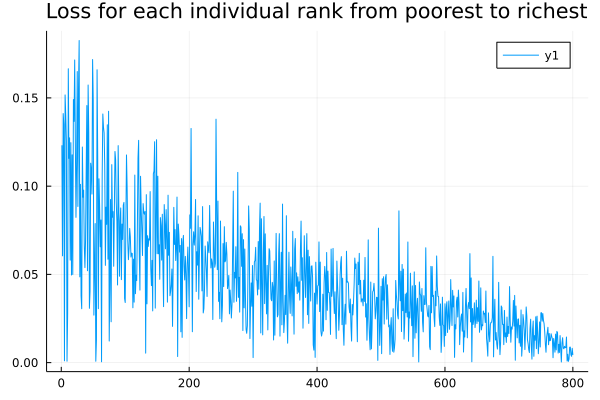

In [23]:
p1=plot(Utility_loss, title="Loss for each individual rank from poorest to richest")
savefig(p1, "Utility_loss.png") # save the most recent fig as filename_string (such as "output.png")
p1

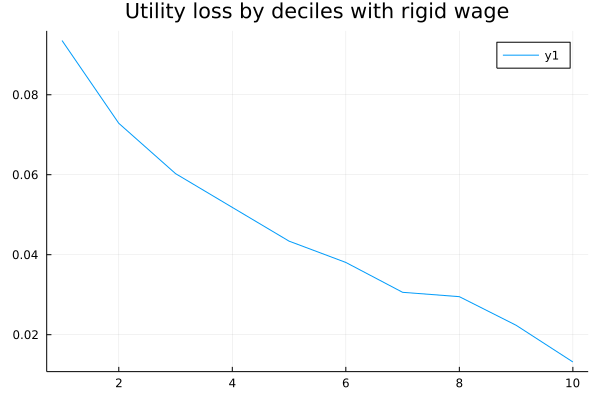

In [31]:
na_n=Int(na/10)
decile=10
dec=reshape(Utility_loss,(na_n,decile))
dec=mean(dec,dims=1)
dec=transpose(dec)

p2=plot(dec, title="Utility loss by deciles with rigid wage")
savefig(p2, "Utility_loss_deciles.png") # save the most recent fig as filename_string (such as "output.png")
p2